# Understand model
Updated 2021-04-08, 2021-05-17, 2015-05-19

This one of our [supplements](https://simularis.github.io/understand_nmec/) to our 
[whitepaper on open-source NMEC tools](https://www.lincusenergy.com/resources/publications/).

In this post, I'll address some common questions about the TOWT model generated by RMV2.0, using code to find the answers.
* What are the temperature breakpoints (TempKnots)?
* What is the regression equation and where are the coefficients?
* Explain segmentation, weighting, and the hyperparameter timescaleDays.

This post will not discuss the occupancy detection, which is the focus of [the next supplement](understand_occupancy.html).

## Executive summary
The segmented time-of-week and temperature (TOWT) model works like this.

$$
Load_{predicted}(T_{db}, t) = \sum_{j=0}^{N_{segments}} w_j(t) \cdot Load_j(T_{db}, t) 
$$

The load will be calculated using a number of weighted load prediction functions. More on the weighting later.
Meanwhile, each $Load_j$ is a piecewise linear regression on temperature, $T_{db}$, also with an intercept
coefficient for each time of week *factor*, $f_{tow}$:

$$
Load_j(T_{db}, t) = \sum_{k=1}^{{K+1}} C_{X_k} X_k(T_{db}) + \sum_{tow=1}^{N_{tow}} C_{f_{tow}} f_{tow}(t)
$$

where the piecewise temperature variables are calculated using a breakpoint algorithm:

$$
\begin{align}
X_1(T_{db}) &= {\rm min}(tempKnot_1,T_{db}) \\
{\rm leftover}_1 &= T_{db} - X_1 \\
X_2(T_{db}) &= {\rm max}(tempKnot_2-tempKnot_1, {\rm min}(0,{\rm leftover}_1)) \\
{\rm leftover}_2 &= T_{db} - (X_1 + X_2) \\
\dots \\
X_{K+1} &= {\rm leftover}_{K}
\end{align}
$$

(here we use the RMV2.0 naming `tempKnot` for the breakpoints) and the TOW factors are indicator variables for the unique day-of-week, time-of-day values that appear in the data. The factor for the first hour of Sunday morning could be defined, for example:

$$
f(t) = \begin{cases}
    1, & \text{if } day(t) = 1 \text{ and } hour(t) = 1 \\
    0, & \text{otherwise}
\end{cases}
$$

In practice, it is not important which time is labeled 1, or if these are hourly or at another interval;
the data determines the actual times of week.

The point of the rest of this article is to pull out the coefficients $C_{X_k}$ and $C_{f_{tow}}$, like this:

```
# The timestamps used for weights
tCenters = trainTime[pointlist]
tCenters
[1] "2006-01-01 01:00:00 MST" "2006-03-15 01:00:00 MST"
[3] "2006-05-27 00:00:00 MST" "2006-08-08 00:00:00 MST"
[5] "2006-10-19 23:00:00 MST" "2006-12-31 23:00:00 MST"

# Considering just one of the Load functions:
# The temperature knots (°C) used to define temperature variables X1, X2, ...:
regOut$tempKnots
[1]  4.444444 12.777778 18.333333 26.666667

# Number of parameters in occupied period model (excluding tempKnots):
regOut$amod$rank
80

# Number of parameters in unoccupied period model (excluding tempKnots):
regOut$bmod$rank
98

# Regression fit coefficients for occupied periods:
regOut$amod

Call:
lm(formula = loadVec ~ . + 0, data = dframe, subset = okocc, 
    weights = weightvec, na.action = na.exclude)

Coefficients:
  ftow33    ftow34    ftow35    ftow36    ftow37    ftow38    ftow39    ftow40  
 889.513  1129.579  1083.434  1055.898  1030.532  1032.293  1053.327  1055.209  
  ftow41    ftow42    ftow43    ftow44    ftow45    ftow57    ftow58    ftow59  
1086.492  1052.536   890.060   781.562   687.989   956.480  1239.358  1193.083  
  ftow60    ftow61    ftow62    ftow63    ftow64    ftow65    ftow66    ftow67  
1166.313  1141.000  1148.110  1175.762  1181.462  1211.249  1164.571   973.030  
  ftow68    ftow69    ftow70    ftow81    ftow82    ftow83    ftow84    ftow85  
 850.676   746.600   652.988   965.799  1251.020  1207.634  1182.726  1152.299  
  ftow86    ftow87    ftow88    ftow89    ftow90    ftow91    ftow92    ftow93  
1162.257  1190.022  1188.593  1217.781  1172.343   980.118   861.779   752.962  
  ftow94   ftow105   ftow106   ftow107   ftow108   ftow109   ftow110   ftow111  
 651.490   954.417  1203.931  1160.355  1132.017  1107.869  1115.496  1140.647  
 ftow112   ftow113   ftow114   ftow115   ftow116   ftow117   ftow118   ftow129  
1143.676  1169.399  1124.270   939.357   831.399   719.134   631.937   970.610  
 ftow130   ftow131   ftow132   ftow133   ftow134   ftow135   ftow136   ftow137  
1249.137  1209.257  1187.430  1162.131  1171.442  1198.762  1200.905  1228.215  
 ftow138   ftow139   ftow140   ftow141   ftow142   ftow153   ftow154   ftow155  
1183.935   985.538   866.343   751.631   653.014   624.374   733.561   685.567  
 ftow156   ftow157   ftow158        X1        X2        X3        X4        X5  
 663.234   661.950   662.021     1.851     4.336    27.944     7.310    45.556  
```

I will also briefly touch on the weighting. If you want, skip ahead to [the good stuff](#The-good-stuff).

## Getting started

If you are new to R and need to look up basic syntax or built-in data types, try these:
* the interactive help() feature of R and the package documentation browser in RStudio.
* Consider the [R Core Team's Reference Index](https://cran.r-project.org/doc/manuals/r-release/fullrefman.pdf)
* Hadley Wickham, one of the RStudio developers, has some really good online book content, covering e.g. [data structures such as data.frame](http://adv-r.had.co.nz/Data-structures.html#data-frames).

Note that the R community has been around a while, and the historical convention for documentation is for a package to be listed in CRAN with a single PDF file of the package documentation. When you install the package, you will have the option to read the documentation locally in your web browser.
However, there is at least one site that scrapes the web and shows the help files for public R packages in HTML format, e.g.
* https://rdrr.io/github/LBNL-ETA/RMV2.0/man/

### Load libraries

In [ ]:
library(ggplot2)
library(dplyr)
library(glue)
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res=300)

### Read the "project.rds" file stored by RMV2.0
To get started, I'm going to open a project file I previously created by running the RMV2.0 add-in.
The following code snippets require that I had installed and used
[my fork of RMV2.0](https://github.com/simularis/RMV2.0/tree/dev)
when running the add-in.
You can install my fork using this command in RStudio.

```
devtools::install_github("simularis/RMV2.0")
```

Let me know if you see any error messages. For this demonstration,
I ran a screening analysis with just one input file, "Data_pre_2_2.csv", from the sample data files
provided with RMV2.0. I created baseline models, selecting TOWT option and the hyperparameter set to
`timescaleDays=90`. I saved the project as `Project_02.19.rds`.

As we load the project file, we can ignore the warning message about the missing namespace.

In [ ]:
rds_file <- "C:/RMV2.0 Workshop/something/Project_02.19.rds"
Project <- readRDS(rds_file)
cat("Your project has the following models.",fill=T)
print(names(Project$model_obj_list$models_list))

## Explore the project file
Now, we are going to explore the project file. This is a data structure designed
by the authors of RMV2.0, mostly composed of named lists, dataframes,
and a few linear regression objects.

In [ ]:
# Uncomment to open a graphical View to browse the data structure.
#View(Project)
# This only works in RStudio, so I'm just including screenshots below.

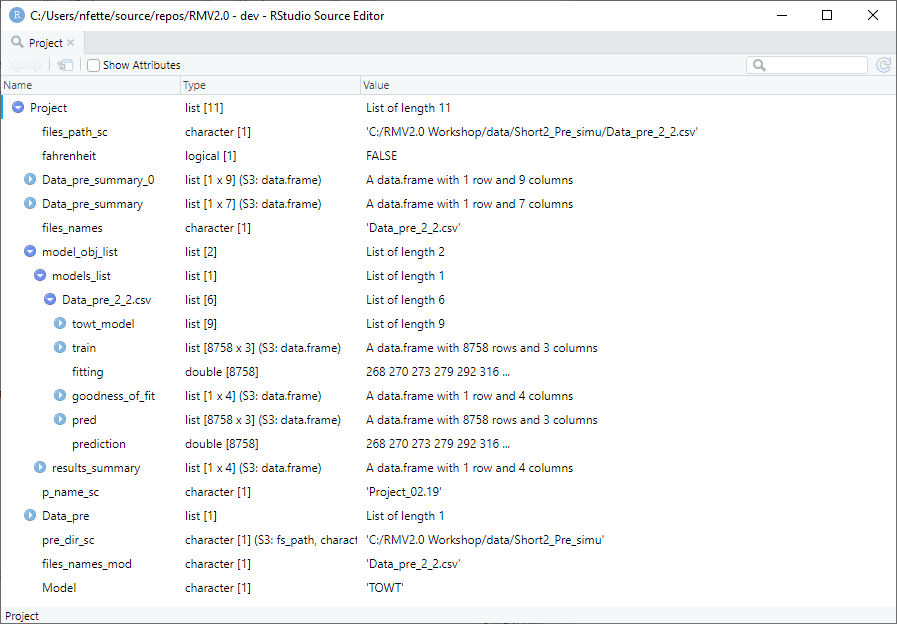

The Project object is a list. Elements of the list can be any data type. To understand what was stored, we want to look at a few important elements:

* `Project$fahrenheit` (logical): Whether the temperature data was read in with units = degrees Fahrenheit.
* `Project$model_obj_list$models_list[["Data_pre_2_2.csv"]]` (list): This data structure includes the regression model coefficients, as well as some calculated quantities like goodness_of_fit.

Note that `Data_pre_2_2.csv` was the name of the data file when we created the model. That name is used to organize the data, in case we had multiple models in the project. We can also refer to that element as `models_list[[1]]`.

As we dive in to explore, note that there is some redundant information and obvious names, so I won't explain it all.

`models[["Data_pre_2_2.csv"]]$train` stores the data used to train regression models, including load and temperature.

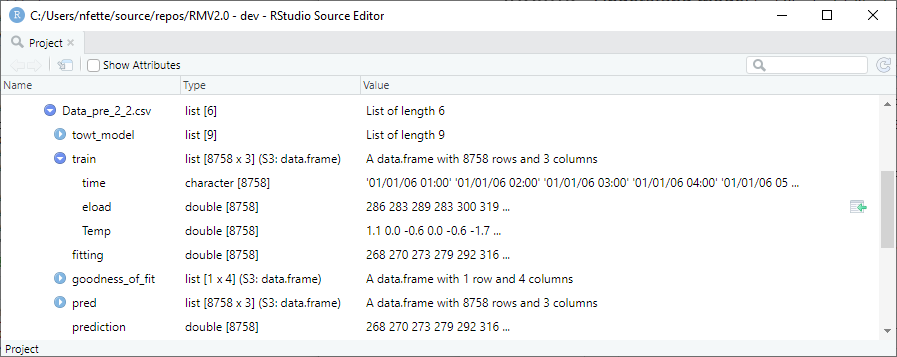

In the `towt_model` data structure:

* Note that `timescaleDays` is the hyperparameter used to break up your 1 year of data into blocks (think seasons or months) at your discretion. I used 90 days, and as a result I had 6 blocks: 365 / 90 = 6, give or take. To be precise, blocks start on the hours indexed by `pointlist`. More on this later.
* In `regOutList` we have stored the outputs of running linear regression fit. This is a list of 6 elements, one for each seasonal block of time.
* `WeightMatrix` contains weights for each (block, timestamp) combination. These are used for weighted regression.
* `PredMatrix` contains load "predictions" using the baseline regression models with the baseline weather data, one time series for each block. For a single time series "prediction", the separate blocks have been re-combined by contraction (matrix multiplication) with the weights, into arrays like `models[["Data_pre_2_2.csv"]]$fitting` and `prediction`. If the model fits, the prediction should be correlated well with baseline data.


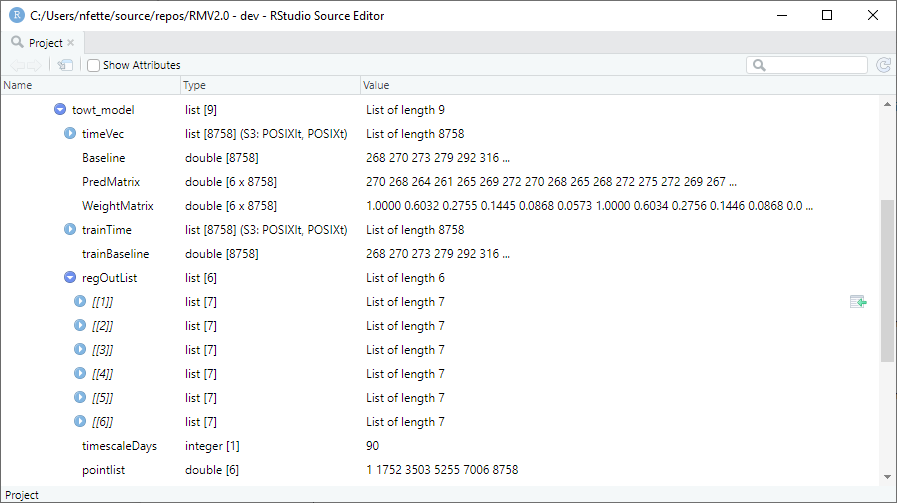

Here is the regression model data structure for the first block, `regOutList[[1]]`. Note:
* `amod` represents a regression model for occupied periods. More on this next.
* `bmod` represents a regression model for unoccupied periods.
* `tempKnots` are the changepoint temperatures This and all internal calculations are kept in degrees Celsius.

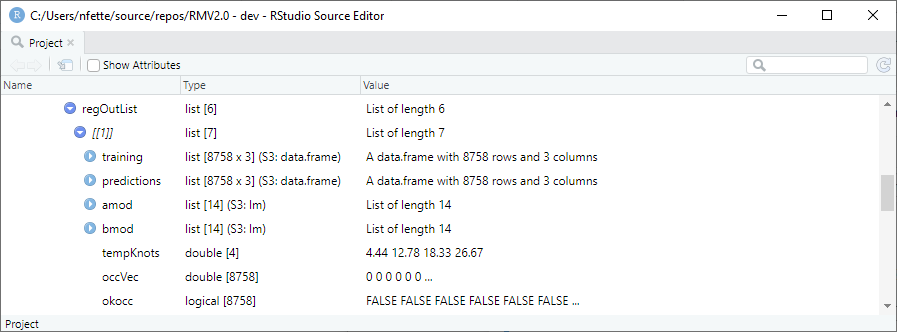

The `amod` element is the output of a call to the `lm` function which performs regression (linear model).
* `lm` is a commonly used function R, not specific to RMV2.0. If you want to write your own regression script, you will probably use `lm` at the heart of it.
* The `call` element remembers how the `lm` function was invoked. The formula `loadVec ~ . + 0` is a lazy way to say that the output of the regression should try to match `loadVec`, and it should be linear function of all the columns (".") in the input data.frame, which is stored as `model`. Those column names are recorded in the `terms` formula:
  * `ftow` is the time of week factor. As a factor, it represents a set of indicator variables like ftow1 ... ftow168, each represent one hour of time-of-week.
  * `X1` through `X5` are the amount by which temperature exceeds the corresponding changepoint from `tempKnots` (and one implicit '0' changepoint).


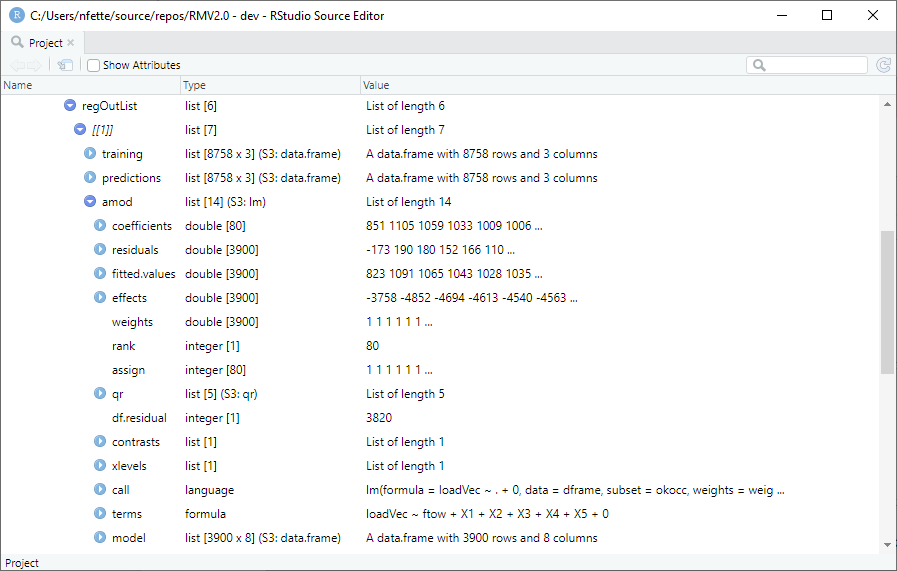

The occupied periods include only some of the time-of-week hours (e.g. 33, 34, ...), which are called the levels of the `ftow` factor. Other levels (e.g. 1, 2, ...) appear in the `bmod` linear model for unoccupied periods.

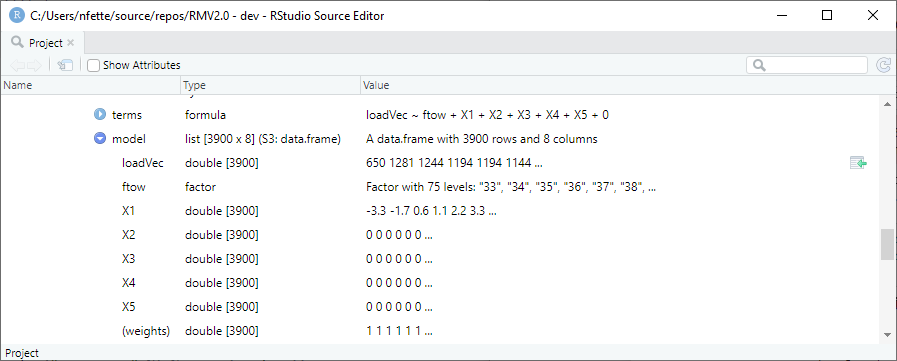

Here we can also see the coefficients. To count them up,

* One coefficient for each changepoint temperature variable: 5
* One coefficient for each "occupied" hour of time-of-week: 75.
 
All together, there are 80 coefficients in the `amod` linear model.

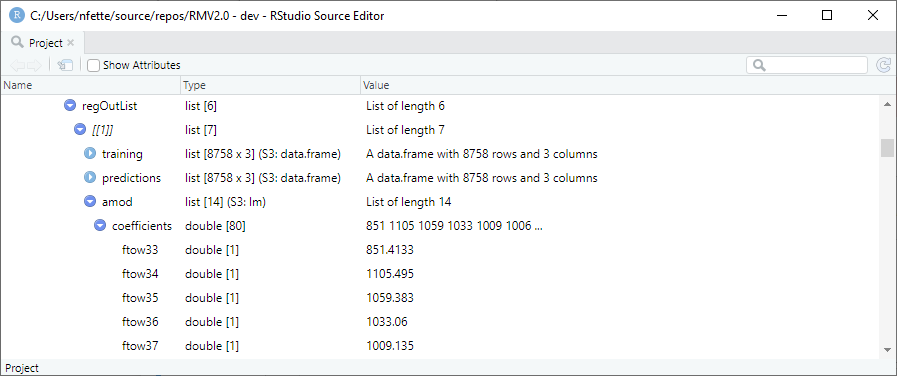

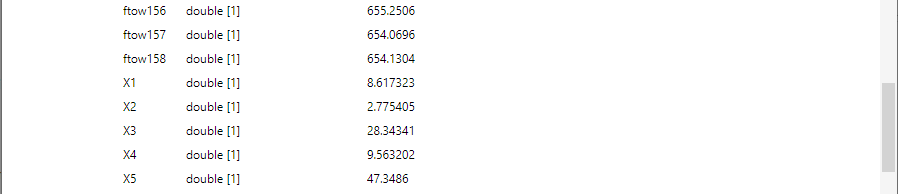

In the `bmod` linear model, we can see a different set of coefficients for the `ftow` factor.

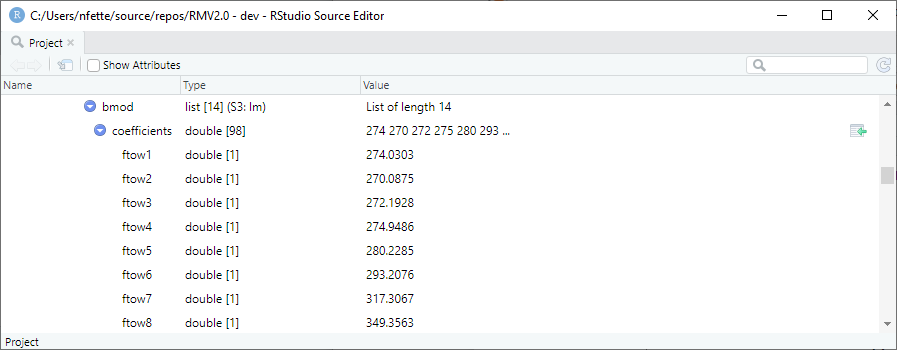

Now that we know a little about the stored data structure, let's start scripting something useful.

### These commands will just print text info summary of the project file structure.

In [ ]:
cat("Project file had the following structure:",fill=T)
print(names(Project))
# Typical for screening analysis
# [1] "files_path_sc"      "fahrenheit"         "Data_pre_summary_0" "Data_pre_summary"   "files_names"        "model_obj_list"
# [7] "p_name_sc"          "Data_pre"           "pre_dir_sc"         "files_names_mod"    "Model"
# Typical for savings analysis
# [1] "Data_pre_summary_0"  "load"                "files_names"         "post_names_sav"      "pre_names_sav"
# [6] "Data_pre"            "files_names_mod"     "p_name_sav"          "post_path_sav"       "Data_pre_summary"
# [11] "fahrenheit"          "post_dir_sav"        "model_obj_list"      "pre_path_sav"        "Data_post"
# [16] "Data_post_summary"   "nre_done"            "Data_post_summary_0" "pre_dir_sav"         "Model"


In [ ]:
cat("Project file has Data_post? (is savings analysis?)",fill=T)
print("Data_post" %in% names(Project))
isSavings = "Data_post" %in% names(Project)
projectType <- if (isSavings) {"savings!"} else {"screenings!"}

cat("Type of models used?",fill=T)
print(Project$Model)
if (Project$Model != "TOWT") {
  cat("Warning: this script only understands TOWT models.",fill=T)
}


In [ ]:
# For the next part, need to pick a model from the models_list by number.
# There is only one data file in the example project, so only one option.
i <- 1
# The model is stored as a list with these named elements.
print(names(Project$model_obj_list$models_list[[i]]$towt_model))
# For convenience, attach the model into the workspace.
# Ignore the warnings about objects in the environment being masked.
attach(Project$model_obj_list$models_list[[i]]$towt_model,name="towt_model")

## The good stuff
Proceed with these steps only if you have my fork of RMV2.0 that saves extra variables.

### Number of segments in segmented model
Here is how RMV2.0 actually used the hyperparameter, timescaleDays, to determine the season blocks.

In [ ]:
dataTime <- if (isSavings) {timeVec} else {trainTime}
npoints = length(dataTime)
t0 = min(dataTime,na.rm=T)
t1 = max(dataTime,na.rm=T)
deltaT = as.numeric(difftime(t1,t0,units="days"))
nsegments = max(1,ceiling(deltaT/timescaleDays))
segmentwidth = (npoints-1)/nsegments
segmentDeltaT = deltaT / nsegments
# This is store in the project file, but just to show how it is computed:
pointlist = floor(sort(npoints-segmentwidth*(0:nsegments))+0.001)
# This is not diretly stored in the project file
tCenters = trainTime[pointlist]

In [ ]:
npoints

In [ ]:
t0
t1
deltaT

In [ ]:
# The hyperparameter timescaleDays
timescaleDays

In [ ]:
# We'll make at least this many segments
deltaT/timescaleDays

In [ ]:
# Rounded up
nsegments

In [ ]:
# The indices of timestamps to be the "center" of each segment.
# Because of (0:nsegments), we get nsegments+1 values.
# It's like rounding up, plus a little extra.
pointlist

In [ ]:
# The timestamps used for weights
tCenters

### The TOWT model object

In [ ]:
length(regOutList)
print(names(regOutList[[1]]))

In [ ]:
nModelRuns <- length(regOutList)
cat(paste("There are ",nModelRuns,"model blocks"),fill=T)
for (irun in 1:nModelRuns) {
  cat(paste("Model block ", irun),fill=T)
  regOut <- regOutList[[irun]]

# Explain how coefficients are linked to input variables in model
#print(regOut$amod$terms)
cat("The formula for the regression:",fill=T)
print(deparse(regOut$amod$terms))
cat("The type of each variable:",fill=T)
print(attr(regOut$amod$terms,"dataClasses"))
cat("The temperature knots used to define temperature variables X1, X2, ...:",fill=T)
print(regOut$tempKnots)

cat(paste("Number of parameters in occupied period model (excluding tempKnots)  :",regOut$amod$rank),fill=T)
cat(paste("Number of parameters in unoccupied period model (excluding tempKnots):",regOut$bmod$rank),fill=T)
cat(fill=T)

}

 ### Coefficients for the first segment

In [ ]:
# Show some or all of the coefficients in a table
cat("Regression fit coefficients for occupied periods:")
#print(head(regOut$amod$coefficients))
#print(tail(regOut$amod$coefficients))
print(regOut$amod)
# Result: e.g. ftow33 ... ftow158, X1 ... X5
# Not all ftow factors appear

cat("Regression fit coefficients for unoccupied periods:")
#print(head(regOut$bmod$coefficients))
#print(tail(regOut$bmod$coefficients))
print(regOut$bmod)
# Result: e.g. ftow1 ... ftow168, X1 ... X5

### Weights for the segmented model
In a segmented model, there is a linear regression associated with each segment of time in the baseline period.
When the model is applied to a given temperature and timestamp, it generates a value from each segmented model,
and adds them up as a weighted average.

In RMV2.0, the model segmentation is done through weights only. That is, instead of splitting
up the baseline data into some number of segments (seasons or months), RMV2.0 authors chose to weight the entire
baseline dataset when training the linear regression model for each segment.
They then use a similarly shaped weighting function when applying the model in the performance period.

So, there are two sets of weights to discuss: the weights for training, and the weights for prediction. The formulas are:

$$
\begin{align}
w_{training,j}(t) = 1 \Big/ \left[1 + \left( \frac{ tCenter_j - t }{timescaleDays} \right)^2 \right] \\
w_{prediction,j}(t) = 1 \Big/ \left[1 + \left( \frac{ tCenter_j - t }{timescaleDays} \right)^2 \right] \\
\end{align}
$$

#### Training weights for weighted linear regression

In [ ]:
# Build dataframe from timeVec (shape [n]) and WeightMatrix (shape [26,n]), transposed
df <- data.frame(
  day = timeVec,
  t_weights=t(WeightMatrix)
)
# "Melt" from wide table to long table (day, variable, value) for the plot
df2 <- reshape2::melt(data=df,id.vars="day")

#library(IRdisplay)
#display(head(df))
#display(tail(df))
head(df)
tail(df)

We can see that there are six ($N_{segments}+1$) time series of weights.
Only one set of training weights is used for any given regression run. So, for the first model
segment, linear regression tries to reduce the product of `t_weights.1` with the residuals,
which will give the best alignment to data in the early part of the baseline period, and so on.


In [ ]:
## Plot training weights, overlaid together
figtitle0 <- if (isSavings) {
  "Raw weights for weighted average of baseline models in post-period\n(Denominator is sum of weights)"
  } else {
    "Weights used to generate baseline models\n(Weighted least squares linear regression)"
  }
figtitle <- glue("{figtitle0}
                  deltaT = {format(deltaT,digits=4)} days, \\
                  timescaleDays = {timescaleDays}, \\
                  segmentDays = {format(segmentDeltaT, digits=4)}")
fig <- ggplot(data = df2, aes(x = day, y = value, colour = variable)) + geom_line() +
  theme(aspect.ratio=0.3) +
  ggtitle(figtitle)
print(fig)

#### Note
* Note that WeightMatrix and timeVec are for the prediction period.
* For the training data, we are saving only trainTime, not the weights.
* For a savings project, prediction and training time intervals may be different!

#### Prediction weights applied in the performance period
This project file was saved for a screening analysis, so we had only baseline data.
But suppose we want to apply this baseline model to dates in the performance period.
What will be the weights for the segmented model?

Let's say the performance period is the year following the baseline (2006), so 2007.

In [ ]:
t0 <- as.POSIXct("2007-01-01 00:00:00")
predTime = seq(t0, by="hour", length.out=8760)

myweights=numeric()
for (irun in 1:nModelRuns) {
    tcenter = dataTime[pointlist[irun]]
    tDiffPred = as.numeric(difftime(tcenter,predTime,units="days"))
    # Statistical weight for prediction period
    weightvecPred = timescaleDays^2/(timescaleDays^2 + tDiffPred^2)
    # The extra parentheses to avoid storing column name 'weightvecPred'
    myweights=cbind(myweights,(weightvecPred))
}

myweights.df = data.frame(
  day = predTime,
  p_weights=myweights
)
head(myweights.df)
tail(myweights.df)

In [ ]:
figtitle <- glue("Raw weights for weighted average of baseline models in post-period \n\\
(Denominator is sum of weights) \n\\
deltaT = {format(deltaT,digits=4)} days, \\
timescaleDays = {timescaleDays}, \\
segmentDays = {format(segmentDeltaT, digits=4)}")
fig <- ggplot(data = reshape2::melt(data=myweights.df,id.vars="day"),
              aes(x = day, y = value, colour = variable)) + geom_line() +
  theme(aspect.ratio=0.3) +
  ggtitle(figtitle)
print(fig)

We can see that model segment 6 (trained to emphasize the end of the baseline period)
will have a dominant role in the prediction early in the year. The plot is less clear as time goes on, so
it may be more illustrative to view that with stacked lines adding up to 100%.

In [ ]:
myweights.df2 = data.frame(
  day = predTime,
  weights=myweights/apply(myweights,1,sum)
)
head(myweights.df2)

In [ ]:
fig <- ggplot(data = reshape2::melt(data=myweights.df2,id.vars="day"),
              aes(x = day, y = value, fill = variable)) +
    geom_area(alpha=0.6 , size=1, colour="black") +
    theme(aspect.ratio=0.3) +
    ggtitle(figtitle)

print(fig)

In my opinion, I find this trend would be hard to justify, physically. Why does segment 6 become more important into
February and March, but then less important in July? I think the application of these weights in the prediction
period requires deeper consideration. Other open-source packages for NMEC that were inspired by RMV2.0 have come
to use different approaches to weighting.

In [ ]:
## Clean up: detach scope
detach("towt_model")

In [ ]:
## Clean up: remove global variables from workspace
rm(rds_file, isSavings, projectType, i, df, df2, tCenters, nModelRuns, irun, regOut)
rm(Project)

## End of supplement 1
To recapitulate, we explored the data structure of the project file saved by RMV2.0. We identified the
linear regression variables and coefficients. And we plotted the weights used for segmentation
at the training and prediction steps.

Thank you for reading. Go back to [article](https://www.lincusenergy.com/resources/publications/) or [supplements](https://simularis.github.io/understand_nmec/).